In [1]:
import numpy as np
import xarray as xr
import nc_time_axis
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import tracks
%matplotlib inline

In [2]:
ds = tracks.load_tracks("../../tracker/jobs/Tracking_TC_RV.seeds/", ext='.seeds')

REF.001: 5.000 years, 2214 tracks
REF.002: 5.000 years, 2146 tracks
REF.003: 5.000 years, 2236 tracks
REF.004: 5.000 years, 2224 tracks
REF.005: 5.000 years, 2284 tracks
REF.006: 5.000 years, 2210 tracks
RCP.001: 5.000 years, 1532 tracks
RCP.002: 5.000 years, 1494 tracks
RCP.003: 5.000 years, 1439 tracks
RCP.004: 5.000 years, 1486 tracks
RCP.005: 5.000 years, 1501 tracks
RCP.006: 5.000 years, 1462 tracks
SAI.001: 5.000 years, 1822 tracks
SAI.002: 5.000 years, 1887 tracks
SAI.003: 5.000 years, 1936 tracks
SAI.004: 5.000 years, 1978 tracks
SAI.005: 5.000 years, 1855 tracks
SAI.006: 5.000 years, 1817 tracks


In [5]:
# Print any remaining unexpected NaNs...
for exp in ds:
    for tid in ds[exp].id.data:
        lons = ds[exp].lon.sel(id=tid)
        if not (lons.dropna('dtime').dtime.diff('dtime') == 0.125).all().item():
            print(exp, n, tid, lons.values[:])

In [3]:
default_kwargs = {  # default line plot kwargs
    'Reference': dict(color='black', lw=2, label='Reference'),
    'RCP8.5': dict(color='orangered', lw=2, label='Control'), 
    'SAI2050': dict(color='dodgerblue', lw=2, label='SAI'),
    'RCP8.5-Reference': dict(color='red', lw=2, label='Control $-$ Ref.'), 
    'SAI2050-Reference': dict(color='green', lw=2, label='SAI $-$ Ref.'),
    'SAI2050-RCP8.5': dict(color='blue', lw=2, label='SAI $-$ Control'),
}

savefigkwargs = dict(dpi=300, bbox_inches='tight', transparent=True)
plt.rcParams['hatch.linewidth'] = 0.3
Zsig = 1.96 # max. Z-score for hatching (1.645 for 90%, 1.96 for 95% CI)

#### tracks

saving ../figures/tracks.seeds.pdf...
CPU times: user 37.9 s, sys: 223 ms, total: 38.2 s
Wall time: 38.7 s


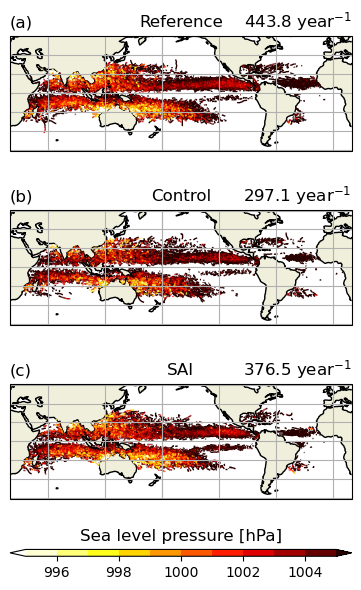

In [23]:
%%time
fname = 'tracks.seeds.pdf'
vmin, vmax, Nv = 995, 1005, 11
clevels = np.linspace(vmin, vmax, Nv)
cmap = plt.get_cmap('hot_r')
extent = (-180,180,-61,61) # (x0, x1, y0, y1)

titles = [
    ['(a)','Reference'],
    ['(b)','Control'],
    ['(c)','SAI'],
]

fig,axs = plt.subplots(3,1,figsize=(3.5,6), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})
for exp, ax, title in zip(ds, axs, titles):
    segments = tracks.track_segments(ds[exp], clevels, central_longitude=200)
    for clevid, segs in segments.items():
        color = cmap((clevid-0.5)/Nv)
        ax.add_collection(LineCollection(segs, color=color, lw=1, 
            transform=ccrs.PlateCarree(central_longitude=200), capstyle='butt'), autolim=False)
    
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_title(title[0], loc='left')
    ax.set_title(title[1])
    ax.set_title(fr'{ds[exp].id.size/ds[exp].num_days*365:.1f} year$^{{-1}}$', loc='right')
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.gridlines()
#     ax.gridlines(draw_labels=(['left','bottom'] if ax==axs[-1] else ['left']))

# create colorbar
colors = cmap((np.arange(Nv+1)-0.5)/Nv)
lcmap = ListedColormap(colors[1:-1])
lcmap.set_extremes(under=colors[0], over=colors[-1], bad=cmap.get_bad())
cb = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin,vmax=vmax),cmap=lcmap), 
             ax=axs, extend='both', orientation='horizontal', aspect=50)
cb.ax.set_title('Sea level pressure [hPa]')

tracks.savefig(fig, fname, **savefigkwargs)

#### track density

In [8]:
%%time
xbins=np.arange(0, 361, 5)
ybins=np.arange(-90, 91, 5)

hists = {exp: (tracks.track_density(ds[exp], xbins=xbins, ybins=ybins).hcount
               .stack(x=['ens','year'])) for exp in ds}
stderr = {exp: tracks.stderr(hists[exp], dim='x') for exp in ds}

for exp in ['RCP8.5-Reference','SAI2050-Reference','SAI2050-RCP8.5']:
    exp1,exp2 = exp.split('-')
    hists[exp] = hists[exp1].mean('x') - hists[exp2].mean('x')
    histsum = hists[exp1].mean('x') + hists[exp2].mean('x')
    hists[exp] = hists[exp].where(histsum!=0)
    stderr[exp] = tracks.stderr(hists[exp1], hists[exp2], dim='x')
for exp in ds:
    hists[exp] = hists[exp].mean('x', keep_attrs=True)
    hists[exp] = hists[exp].where(hists[exp]!=0)

CPU times: user 31.3 s, sys: 20.5 ms, total: 31.3 s
Wall time: 31.8 s


In [40]:
!rm ../figures/track_density.seeds.pdf

saving ../figures/track_density.seeds.pdf...


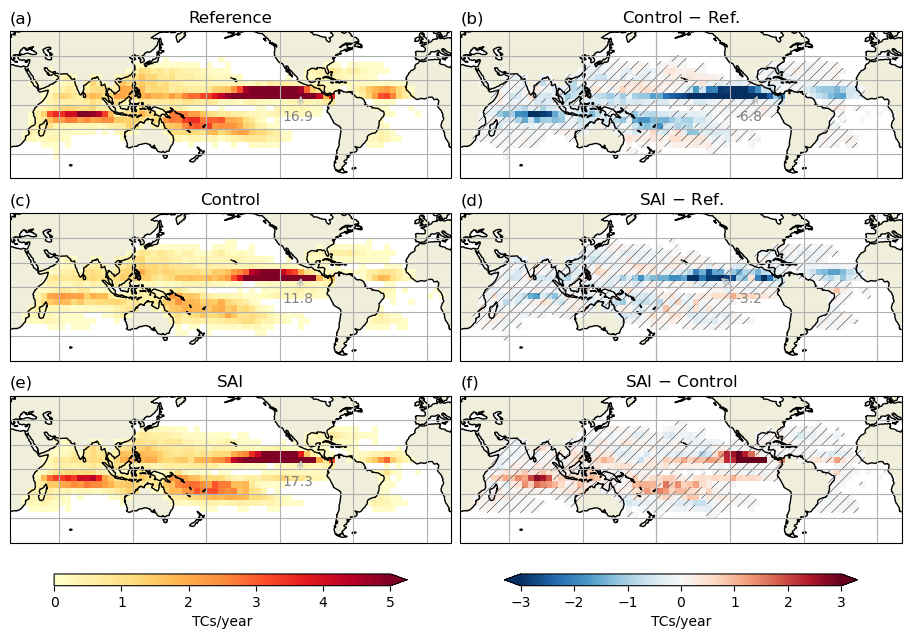

In [41]:
fname = 'track_density.seeds.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {
    '(a)': 'Reference',
    '(b)': 'Control $-$ Ref.',
    '(c)': 'Control',
    '(d)': 'SAI $-$ Ref.',
    '(e)': 'SAI',
    '(f)': 'SAI $-$ Control'
}
vlims = {'ref':{'vmin':0, 'vmax':5}, 'diff':{'vmin':-3,'vmax':3}}

def annotate_minmax(ax, xytext, data, method='max'):
    if method == 'min':
        xtr = data.isel(data.argmin(...))
    elif method == 'max':
        xtr = data.isel(data.argmax(...))
    ax.annotate(xy=(xtr.xbins,xtr.ybins), text=f"{xtr:.1f}", c='grey', size=10, va='center', ha='center', xytext=(255,-10), 
            transform=ccrs.PlateCarree(), arrowprops=dict(arrowstyle="->",shrinkB=0,ec='silver'))
    return

def annotate_minmax(ax, xytext, data, method='max'):
    if method == 'min':
        xtr = data.argmin(...)
    elif method == 'max':
        xtr = data.argmax(...)
    x = data.xbins.isel(xtr, missing_dims='ignore')
    y = data.ybins.isel(xtr, missing_dims='ignore')
    z = data.isel(xtr)
    #ax.scatter(x,y,c='w', transform=ccrs.PlateCarree())
    ax.annotate(xy=(x,y), text=f"{z:.1f}", c='grey', size=10, va='center', ha='center', xytext=(255,-10), 
            transform=ccrs.PlateCarree(), arrowprops=dict(arrowstyle="->",shrinkB=0,ec='silver'))
    return

fig, axs = plt.subplots(3,2, figsize=(9,6.3), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax = axs[0,0] # ref. track density
cfdata = hists['Reference']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
annotate_minmax(ax, (255,-10), cfdata, method='max')
#ax.scatter(mx.xbins, mx.ybins, c='r', s=1, transform=ccrs.PlateCarree())

ax = axs[1,0] # RCP track density
cfdata = hists['RCP8.5']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
annotate_minmax(ax, (255,-10), cfdata, method='max')

ax = axs[2,0] # SAI track density
cfdata = hists['SAI2050']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
annotate_minmax(ax, (255,-10), cfdata, method='max')

ax = axs[0,1] # RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,1] # SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[2,1] # SAI-RCP track density
exps = 'SAI2050-RCP8.5'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=2, marker='x', linewidths=0.3, c='k', edgecolors='none', transform=ccrs.PlateCarree())
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

for ax,(lab,title) in zip(axs.flatten(), titles.items()):
    ax.gridlines()
    ax.coastlines()
    #ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.set_title(title)
    ax.set_title(lab, loc='left')
    ax.set_extent((0,360,-60,60), crs=ccrs.PlateCarree())

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('TCs/year')
cb = fig.colorbar(cf_ref, ax=axs[:,0], extend='max', **cbkwargs)
cb.ax.set_xlabel('TCs/year')

tracks.savefig(fig, fname, **savefigkwargs)

../figures/track_density_4panel.seeds.pdf already exists, cannot overwrite


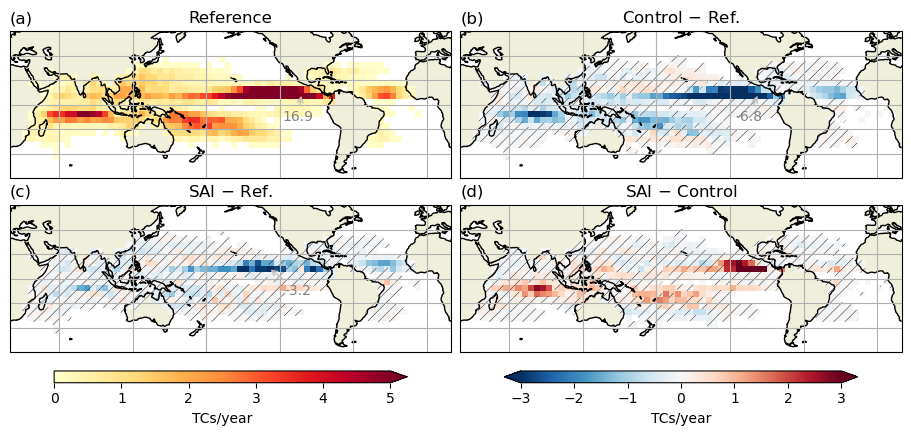

In [43]:
fname = 'track_density_4panel.seeds.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {
    '(a)': 'Reference',
    '(b)': 'Control $-$ Ref.',
    '(c)': 'SAI $-$ Ref.',
    '(d)': 'SAI $-$ Control',
}
vlims = {'ref':{'vmin':0, 'vmax':5}, 'diff':{'vmin':-3,'vmax':3}}

def annotate_minmax(ax, xytext, data, method='max'):
    if method == 'min':
        xtr = data.isel(data.argmin(...))
    elif method == 'max':
        xtr = data.isel(data.argmax(...))
    ax.annotate(xy=(xtr.xbins,xtr.ybins), text=f"{xtr:.1f}", c='grey', size=10, va='center', ha='center', xytext=(255,-10), 
            transform=ccrs.PlateCarree(), arrowprops=dict(arrowstyle="->",shrinkB=0,ec='silver'))
    return

fig, axs = plt.subplots(2,2, figsize=(9,4.2), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax = axs[0,0] # ref. track density
cfdata = hists['Reference']#.hcount.mean('x')
#cfdata.data[cfdata==0] = np.nan
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
annotate_minmax(ax, (255,-10), cfdata, method='max')
#ax.scatter(mx.xbins, mx.ybins, c='r', s=1, transform=ccrs.PlateCarree())

ax = axs[0,1] # RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists[exps]
# cfdata = (hists[exps[0]].hcount.mean('x')
#           -hists[exps[1]].hcount.mean('x'))
# cfdata.data[cfdata==0] = np.nan
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,0] # SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists[exps]
# cfdata = (hists[exps[0]].hcount.mean('x')
#           -hists[exps[1]].hcount.mean('x'))
# cfdata.data[cfdata==0] = np.nan
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,1] # SAI-RCP track density
exps = 'SAI2050-RCP8.5'
cfdata = hists[exps]
# cfdata = (hists[exps[0]].hcount.mean('x')
#           -hists[exps[1]].hcount.mean('x'))
# cfdata.data[cfdata==0] = np.nan
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=2, marker='x', linewidths=0.3, c='k', edgecolors='none', transform=ccrs.PlateCarree())
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

for ax,(lab,title) in zip(axs.flatten(), titles.items()):
    ax.gridlines()
    ax.coastlines()
    #ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.set_title(title)
    ax.set_title(lab, loc='left')
    ax.set_extent((0,360,-60,60), crs=ccrs.PlateCarree())

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('TCs/year')
cb = fig.colorbar(cf_ref, ax=axs[:,0], extend='max', **cbkwargs)
cb.ax.set_xlabel('TCs/year')

tracks.savefig(fig, fname, **savefigkwargs)

#### genesis track density

In [10]:
# xbins=np.arange(0, 361, 7.5)
# ybins=np.arange(-90, 91, 7.5)
# hists = {exp: tracks.track_density(ds[exp].isel(dtime=0), xbins=xbins, ybins=ybins) for exp in ds}
# hists = {exp: hist.stack(x=['ens','year']) for exp,hist in hists.items()}
# stderr = {exp: hists[exp].hcount.std('x', ddof=1)/np.sqrt(hists[exp].x.size) for exp in hists}

In [44]:
%%time
xbins=np.arange(0, 361, 7.5)
ybins=np.arange(-90, 91, 7.5)

hists = {exp: (tracks.track_density(
    ds[exp].isel(dtime=0), xbins=xbins, ybins=ybins
).hcount.stack(x=['ens','year'])) for exp in ds}
stderr = {exp: tracks.stderr(hists[exp], dim='x') for exp in ds}

for exp in ['RCP8.5-Reference','SAI2050-Reference','SAI2050-RCP8.5']:
    exp1,exp2 = exp.split('-')
    hists[exp] = hists[exp1].mean('x') - hists[exp2].mean('x')
    histsum = hists[exp1].mean('x') + hists[exp2].mean('x')
    hists[exp] = hists[exp].where(histsum!=0)
    stderr[exp] = tracks.stderr(hists[exp1], hists[exp2], dim='x')
for exp in ds:
    hists[exp] = hists[exp].mean('x', keep_attrs=True)
    hists[exp] = hists[exp].where(hists[exp]!=0)

CPU times: user 1.14 s, sys: 2.01 ms, total: 1.14 s
Wall time: 1.16 s


saving ../figures/track_density_genesis.seeds.pdf...


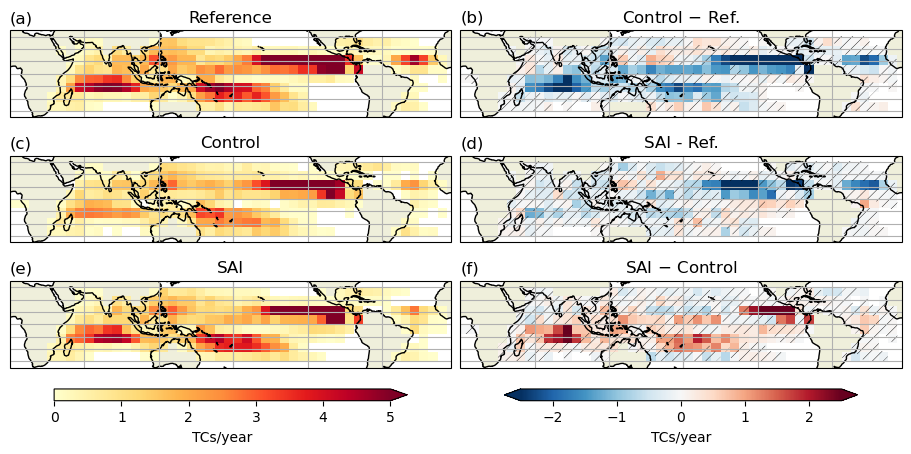

In [49]:
fname = 'track_density_genesis.seeds.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {
    '(a)': 'Reference',
    '(b)': 'Control $-$ Ref.',
    '(c)': 'Control',
    '(d)': 'SAI - Ref.',
    '(e)': 'SAI',
    '(f)': 'SAI $-$ Control'
}
vlims = {'ref':{'vmin':0, 'vmax':5}, 'diff':{'vmin':-2.5,'vmax':2.5}}

fig, axs = plt.subplots(3,2, figsize=(9,4.5), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

ax = axs[0,0] # ref. track density
cfdata = hists['Reference']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)

ax = axs[1,0] # RCP track density
cfdata = hists['RCP8.5']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)

ax = axs[2,0] # SAI track density
cfdata = hists['SAI2050']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)

ax = axs[0,1] # RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

ax = axs[1,1] # SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

ax = axs[2,1] # SAI-RCP track density
exps = 'SAI2050-RCP8.5'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

for ax,(lab,title) in zip(axs.flatten(), titles.items()):
    ax.gridlines()
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.set_title(title)
    ax.set_title(lab, loc='left')
    ax.set_extent((0,356,-35,35), crs=ccrs.PlateCarree())

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('TCs/year')
cb = fig.colorbar(cf_ref, ax=axs[:,0], extend='max', **cbkwargs)
cb.ax.set_xlabel('TCs/year')

tracks.savefig(fig, fname, **savefigkwargs)

In [50]:
%%time

def lat_density(ds, bins):
    ensyear = [(int(ens),int(year)) 
               for ens,grp in ds.year.groupby('ens') 
               for year in np.unique(grp)]

    lat_hist = np.zeros((len(ensyear),len(bins)-1))
    for ey,(ens,year) in enumerate(ensyear):
        dsi = ds.where((ds.ens==ens) & (ds.year==year), drop=True)
        lat_hist[ey],_ = np.histogram(dsi.lat, bins=bins)
    cbins = (np.array(bins)[1:] + np.array(bins[:-1]))/2
    return xr.DataArray(data=lat_hist, coords={'bins':cbins}, dims=('ensyear','bins'))

# calculate genesis latitude density (TCs/year per 2.5deg latitude box)
bin_edges = np.arange(-90,90.1,2.5)
hist_lat = xr.Dataset(
    {exp: lat_density(ds[exp].isel(dtime=0), bins=bin_edges) for exp in ds},
    coords={'bin_edges':bin_edges}
)

CPU times: user 948 ms, sys: 7.85 ms, total: 956 ms
Wall time: 965 ms


In [51]:
%%time
# calculate 95% CI for genesis latitude density in Reference
qs = [0.025,0.975] # quantiles used for 95% CI

hist_lat_CI = xr.zeros_like(hist_lat.bins).expand_dims(q=qs).copy()
dsi = hist_lat['Reference']
for bn in dsi.sum('ensyear').where(dsi.sum('ensyear')!=0, drop=True).bins.data:
    hist_lat_CI.loc[dict(bins=bn)] = tracks.bootstrap(
        dsi.sel(bins=bn), np.mean, qs=qs)

CPU times: user 2.32 s, sys: 2.83 ms, total: 2.33 s
Wall time: 2.35 s


saving ../figures/track_density_genesis_lat.seeds.pdf...


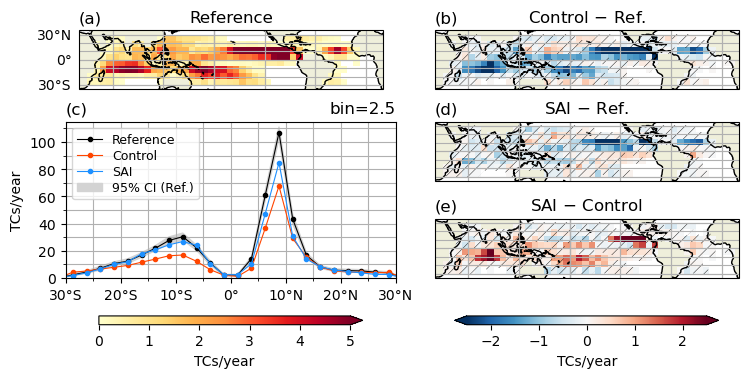

In [59]:
fname = 'track_density_genesis_lat.seeds.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {  # for maps only
    '(a)': 'Reference',
    '(b)': 'Control $-$ Ref.',
    '(X1)': 'Y',
    '(d)': 'SAI $-$ Ref.',
    '(X2)': 'Y',
    '(e)': 'SAI $-$ Control',
}
vlims = {'ref':{'vmin':0, 'vmax':5}, 'diff':{'vmin':-2.5,'vmax':2.5}}

fig, axs = plt.subplots(3,2, figsize=(7.5,3.66), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax = axs[0,0] # ref. track density
cfdata = hists['Reference']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
ax.gridlines(draw_labels=['left'], ylocs=[-30,0,30])

ax = axs[1,0] # RCP track density
cfdata = hists['RCP8.5']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)

ax = axs[2,0] # SAI track density
cfdata = hists['SAI2050']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)

ax = axs[0,1] # RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=['right'], ylocs=[-30,0,30])

ax = axs[1,1] # SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=['right'], ylocs=[-30,0,30])

ax = axs[2,1] # SAI-RCP track density
exps = 'SAI2050-RCP8.5'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=['right'], ylocs=[-30,0,30])



for ax,(lab,title) in zip(axs.flat, titles.items()):
    ax.gridlines()
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.set_title(title)
    ax.set_title(lab, loc='left')
    ax.set_extent((0,356,-35,35), crs=ccrs.PlateCarree())


gs = axs[0,0].get_gridspec()
for ax in axs[1:,0]:
    ax.remove()
#axs = axs[:-1,:]

ax_big = fig.add_subplot(gs[1:,0])
# ax_big = fig.add_axes( [
#     axs[0,0].get_position().xmin, # left
#     axs[2,1].get_position().ymin, # bottom
#     axs[0,0].get_position().width, # width
#     axs[1,1].get_position().ymax - axs[2,1].get_position().ymin, # height
# ])
# pos = axs[1,1].get_position().union((axs[1,1].get_position(), axs[2,1].get_position()))
# ax_big = fig.add_axes([0,0.2,axs[0,0].get_position().width,0.47])

ax = ax_big
ax.set_title('(c)', loc='left')
ax.set_title('bin=2.5', loc='right')
ax.plot(hist_lat.bins, hist_lat['Reference'].mean('ensyear'), marker='.', **(default_kwargs['Reference']|dict(lw=.8)))
ax.plot(hist_lat.bins, hist_lat['RCP8.5'].mean('ensyear'), marker='.', **(default_kwargs['RCP8.5']|dict(lw=.8)))
ax.plot(hist_lat.bins, hist_lat['SAI2050'].mean('ensyear'), marker='.', **(default_kwargs['SAI2050']|dict(lw=.8)))
ax.fill_between(hist_lat.bins, hist_lat_CI.isel(q=0), hist_lat_CI.isel(q=1), step=None, color='lightgrey', alpha=1, label='95% CI (Ref.)',zorder=0)
ax.set_xticks(range(-30,31,5), minor=True)
ax.set_xticks(range(-30,31,10), labels=['30°S','20°S','10°S','0°','10°N','20°N','30°N'])
ax.set_yticks(range(0,111,10), minor=True)
ax.set_yticks(range(0,111,20))
ax.set_xlim([-30,30])
ax.set_ylim([0,115])
ax.set_ylabel('TCs/year')
ax.legend(fontsize=9, loc='upper left', labelspacing=0.25)
ax.grid(which='both')

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('TCs/year')
cb = fig.colorbar(cf_ref, ax=[axs[0,0],ax_big], extend='max', **cbkwargs)
cb.ax.set_xlabel('TCs/year')

tracks.savefig(fig, fname, **savefigkwargs)


#### track density major vs minor TCs

#### track density 10% strongest by U10

#### TC hours per day

In [16]:
def TChoursperday(ds):
    """Calculate total TC hours per day in dataset ds"""
    out = {}
    for ens in np.unique(ds.ens): 
        dsi = ds.where(ds.ens==ens, drop=True)#.dropna('id',how='all')
        times_in = dsi.time.stack(x=[...]).dropna('x')
        times_in -= 0.125 # set to start of time bounds
        times_out = np.arange(times_in.min()//1, times_in.max()//1+1, 0.125)
        out[ens] = xr.DataArray(data=np.zeros(times_out.size), 
            coords={'time':('time',times_out,dsi.time.attrs)},
            name='freq', attrs={'long_name':'TC frequency','units':'TC hours per day'})
        vals, counts = np.unique(times_in, return_counts=True)
        out[ens][np.searchsorted(out[ens].time, vals)] = counts*3
        out[ens] = xr.decode_cf(out[ens].to_dataset()).freq
    out = xr.concat(out.values(), 'ens', join='outer', fill_value=0)
    out['ens'] = out.ens + 1
    out = out.coarsen(time=8).sum()
    return out


exp = ['Reference','RCP8.5','SAI2050'][2]
lats = ds[exp].isel(dtime=0).lat
ds_NH = ds[exp].where(lats>0).dropna('id', how='all')
freq = TChoursperday(ds_NH)
ydata = tracks.assign_dayofyear(freq)

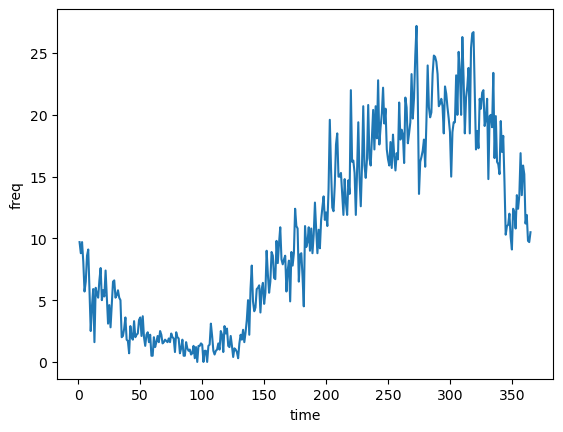

In [12]:
ydata.mean(('year','ens')).plot()

In [4]:
# create annual mean and variance of NH/SH daily TC hours
ydata_NH = {}
for exp in ds:
    lats = ds[exp].isel(dtime=0).lat
    ds_NH = ds[exp].where(lats>0).dropna('id', how='all')
    ydata = tracks.assign_dayofyear(tracks.TChoursperday(ds_NH))
    ydata = ydata.roll(dayofyear=-90, roll_coords=True)
    ydata['doy'] = ('dayofyear', np.array(range(365))+ydata.dayofyear[0].item()) # monotonically increasing doy needed for plotting
    ydata_NH[exp] = ydata

ydata_SH = {}
for exp in ds:
    lats = ds[exp].isel(dtime=0).lat
    ds_SH = ds[exp].where(lats<=0).dropna('id', how='all')
    ydata = tracks.assign_dayofyear(tracks.TChoursperday(ds_SH))
    ydata = ydata.roll(dayofyear=154, roll_coords=True)
    ydata['doy'] = ('dayofyear', np.array(range(365))+ydata.dayofyear[0].item()) # monotonically increasing doy needed for plotting
    ydata_SH[exp] = ydata

saving ../figures/TC_count_NH_SH.seeds.pdf...


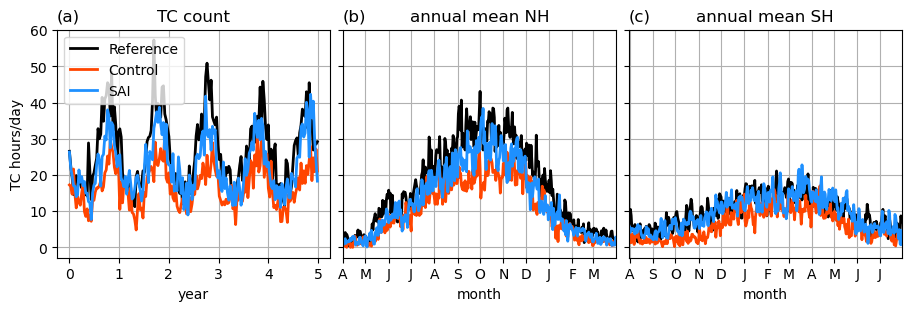

In [5]:
figname = 'TC_count_NH_SH.seeds.pdf'

fig, axs = plt.subplots(1,3, figsize=(9,3), sharey=True, layout='constrained')

ax = axs[0]
for exp in ds:
    ydata = tracks.TChoursperday(ds[exp])
    ydata = ydata.resample(time='10D').mean()
    ydata['time'] = ydata.time - cftime.DatetimeNoLeap(ydata.time[0].dt.year,1,1)
    ax.plot(ydata.time.dt.total_seconds()/86400/365, ydata.mean('ens'), **default_kwargs[exp])
t = ax.set_title("TC count")
ax.set_title('(a)', loc='left')
ax.set_xlabel("year")
ax.legend()
ax.grid()
ax.set_ylabel("TC hours/day")

xticks = np.array([0,31,59,90,120,151,181,212,243,273,304,334]) + 1
xticklabs = ['J','F','M','A','M','J','J','A','S','O','N','D']

ax = axs[1]
for exp in ds:
    ydata = ydata_NH[exp]
    ids = [np.abs(ydata.dayofyear-xt).argmin().item() for xt in xticks]
    ax.plot(ydata.doy, ydata.mean(('ens','year')), **default_kwargs[exp])
ax.set_xticks(ydata.doy[ids], xticklabs)
ax.set_xlim((ydata.doy.min(),ydata.doy.max()))
t = ax.set_title("annual mean NH")
ax.set_title("(b)", loc='left')
ax.set_xlabel("month")
ax.grid()

ax = axs[2]
for exp in ds:
    ydata = ydata_SH[exp]
    ids = [np.abs(ydata.dayofyear-xt).argmin().item() for xt in xticks]
    ax.plot(ydata.doy, ydata.mean(('ens','year')), **default_kwargs[exp])
ax.set_xticks(ydata.doy[ids], xticklabs)
ax.set_xlim((ydata.doy.min(),ydata.doy.max()))
t = ax.set_title("annual mean SH")
ax.set_title("(c)", loc="left")
ax.set_xlabel("month")
ax.grid()

tracks.savefig(fig, figname, **savefigkwargs)

Daily sum of TC hours, i.e. the track duration on any given day summed over all active tracks. a) shows the ensemble mean daily sum of TC hours, smoothed by a 10-day running mean, b) and c) show the ensemble mean interannual mean daily sum of TC hours for the Northern and Southern Hemisphere, respectively.

In [6]:
n = 20 # window size (centered) along dayofyear

ydata_NHMA = {exp: tracks.rolling_rolling(ydata, n, 'dayofyear', 'ddoy').stack(x=['ens','year']) 
              for exp,ydata in ydata_NH.items()}
ydata_SHMA = {exp: tracks.rolling_rolling(ydata, n, 'dayofyear', 'ddoy').stack(x=['ens','year']) 
              for exp,ydata in ydata_SH.items()}

# calculate 95% confidence interval for Reference
exp = 'Reference'
ydata_NHMACI = xr.zeros_like(ydata_NHMA[exp].mean(('x','ddoy'))).expand_dims(qs=[0.025,0.975]).copy()
for doy in ydata_NHMACI.dayofyear.data:
    q1, q2 = tracks.bootstrap(ydata_NHMA[exp].sel(dayofyear=doy).mean('ddoy'), np.mean)
    ydata_NHMACI.loc[dict(dayofyear=doy)] = [q1, q2]
    
ydata_SHMACI = xr.zeros_like(ydata_SHMA[exp].mean(('x','ddoy'))).expand_dims(qs=[0.025,0.975]).copy()
for doy in ydata_SHMACI.dayofyear.data:
    q1, q2 = tracks.bootstrap(ydata_SHMA[exp].sel(dayofyear=doy).mean('ddoy'), np.mean)
    ydata_SHMACI.loc[dict(dayofyear=doy)] = [q1, q2]

# calculate rolling window mean and standard error 
ydata_NHMA = {exp: (ydata.mean(('x','ddoy'), keep_attrs=True), ydata.std('x', ddof=1, keep_attrs=True).mean('ddoy', keep_attrs=True)/np.sqrt(ydata.x.size))
             for exp,ydata in ydata_NHMA.items()}
ydata_SHMA = {exp: (ydata.mean(('x','ddoy'), keep_attrs=True), ydata.std('x', ddof=1, keep_attrs=True).mean('ddoy', keep_attrs=True)/np.sqrt(ydata.x.size))
             for exp,ydata in ydata_SHMA.items()}

saving ../figures/TC_count_NH_SH_MA20.seeds.pdf...


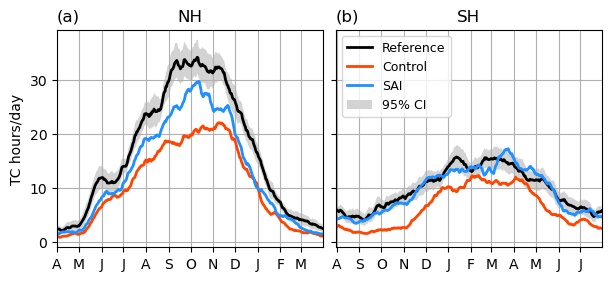

In [7]:
fname = 'TC_count_NH_SH_MA20.seeds.pdf'
fig, axs = plt.subplots(1,2, figsize=(6,2.7),sharey='row', layout='constrained')

xticks = np.array([0,31,59,90,120,151,181,212,243,273,304,334]) + 1
xticklabs = ['J','F','M','A','M','J','J','A','S','O','N','D']

ax = axs[0]
ydata = ydata_NHMA['Reference'][0]
ydataCI = ydata_NHMACI
ids = [np.abs(ydata.dayofyear-xt).argmin().item() for xt in xticks]
ax.set_xticks(ydata.doy[ids], xticklabs)
ax.set_xlim((ydata.doy.min(),ydata.doy.max()))
for exp,ydata in ydata_NHMA.items():
    y_mean, y_se = ydata
    ax.plot(y_mean.doy, y_mean, **default_kwargs[exp])
ax.fill_between(ydata_NHMACI.doy, ydata_NHMACI.isel(qs=0), 
                ydata_NHMACI.isel(qs=1), fc='lightgrey', label='95% CI')  

ax = axs[1]
ydata = ydata_SHMA['Reference'][0]
ydataCI = ydata_SHMACI
ids = [np.abs(ydata.dayofyear-xt).argmin().item() for xt in xticks]
ax.set_xticks(ydata.doy[ids], xticklabs)
ax.set_xlim((ydata.doy.min(),ydata.doy.max()))
for exp,ydata in ydata_SHMA.items():
    y_mean, y_se = ydata
    ax.plot(y_mean.doy, y_mean, **default_kwargs[exp])
ax.fill_between(ydata_SHMACI.doy, ydata_SHMACI.isel(qs=0), 
                ydata_SHMACI.isel(qs=1), fc='lightgrey', label='95% CI')    

axs[0].set_ylabel('TC hours/day')
axs[0].set_title('NH')
axs[0].set_title('(a)', loc='left')
axs[1].set_title('SH')
axs[1].set_title('(b)', loc='left')
axs[1].legend(loc='upper left', fontsize=9)

[axi.grid() for axi in axs.flat]

tracks.savefig(fig, fname, **savefigkwargs)

In [8]:
exp = 'Reference'
TCdays_NHref = ydata_NH[exp].mean(('year','ens')).sum('dayofyear')/24
TCdays_SHref = ydata_SH[exp].mean(('year','ens')).sum('dayofyear')/24

print(f"NH: TC days/year (% change from Ref.)")
for exp in ds:
    TCdays_NH = ydata_NH[exp].mean(('year','ens')).sum('dayofyear')/24
    print(f"{exp:9}: {TCdays_NH:.1f} ({(TCdays_NH-TCdays_NHref)/TCdays_NHref*100:+.1f}%)")

print(f"\nSH: TC days/year (% change from Ref.)")
for exp in ds:
    TCdays_SH = ydata_SH[exp].mean(('year','ens')).sum('dayofyear')/24
    print(f"{exp:9}: {TCdays_SH:.1f} ({(TCdays_SH-TCdays_SHref)/TCdays_SHref*100:+.1f}%)")

NH: TC days/year (% change from Ref.)
Reference: 256.5 (+0.0%)
RCP8.5   : 160.2 (-37.5%)
SAI2050  : 199.6 (-22.2%)

SH: TC days/year (% change from Ref.)
Reference: 149.9 (+0.0%)
RCP8.5   : 96.3 (-35.8%)
SAI2050  : 144.3 (-3.7%)


saving ../figures/TC_count_NH_SH_diff.seeds.pdf...


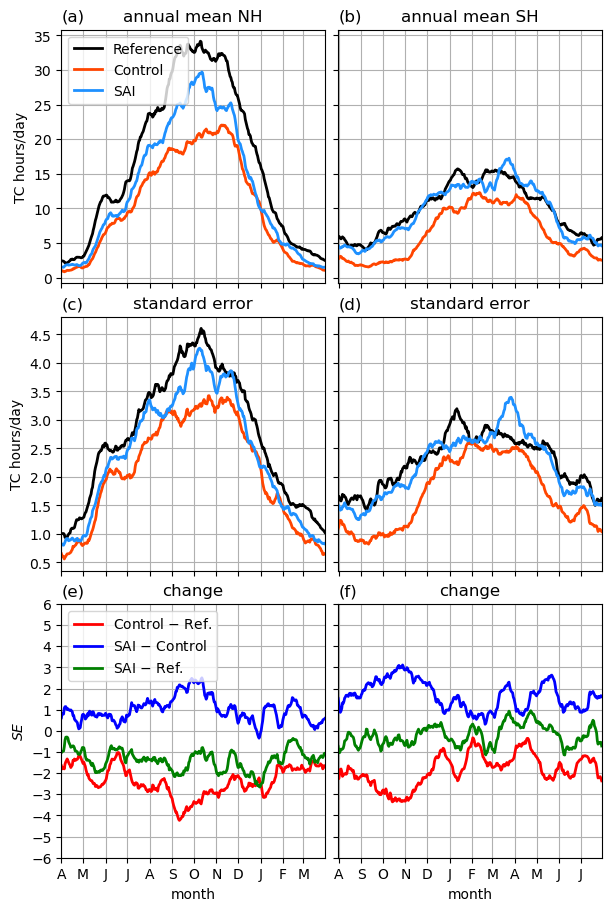

In [9]:
fname = 'TC_count_NH_SH_diff.seeds.pdf'
fig, axs = plt.subplots(3,2, figsize=(6,9), sharex='col',sharey='row', layout='constrained')

xticks = np.array([0,31,59,90,120,151,181,212,243,273,304,334]) + 1
xticklabs = ['J','F','M','A','M','J','J','A','S','O','N','D']

for ax, plot_data in zip([axs[:,0],axs[:,1]],[ydata_NHMA,ydata_SHMA]):
    ydata = plot_data['Reference'][0]
    ids = [np.abs(ydata.dayofyear-xt).argmin().item() for xt in xticks]
    ax[0].set_xticks(ydata.doy[ids], xticklabs)
    ax[0].set_xlim((ydata.doy.min(),ydata.doy.max()))
    for exp,ydata in plot_data.items():
        y_mean, y_se = ydata
        ax[0].plot(y_mean.doy, y_mean, **default_kwargs[exp])
        ax[1].plot(y_se.doy, y_se, **default_kwargs[exp])
    
    ax[2].set_yticks(range(-6,7))
    ax[2].set_ylim([-6,6])
    for exps in ['RCP8.5-Reference','SAI2050-RCP8.5','SAI2050-Reference']:
        exp2, exp1 = exps.split('-')
        y_mean = plot_data[exp2][0] - plot_data[exp1][0]
        y_se = np.sqrt(plot_data[exp2][1]**2 + plot_data[exp1][1]**2)/np.sqrt(2)
        ax[2].plot(y_mean.doy, y_mean/y_se, **default_kwargs[exps])

axs[-1,0].set_xlabel("month")
axs[-1,1].set_xlabel("month")
axs[0,0].set_ylabel('TC hours/day')
axs[1,0].set_ylabel('TC hours/day')
axs[2,0].set_ylabel('$SE$')
axs[0,0].set_title('annual mean NH')
axs[0,0].set_title('(a)', loc='left')
axs[0,1].set_title('annual mean SH')
axs[0,1].set_title('(b)', loc='left')
axs[1,0].set_title('standard error')
axs[1,0].set_title('(c)', loc='left')
axs[1,1].set_title('standard error')
axs[1,1].set_title('(d)', loc='left')
axs[2,0].set_title('change')
axs[2,0].set_title('(e)', loc='left')
axs[2,1].set_title('change')
axs[2,1].set_title('(f)', loc='left')
axs[0,0].legend(loc='upper left')
axs[2,0].legend(loc='upper left')

[axi.grid() for axi in axs.flat]

tracks.savefig(fig, fname, **savefigkwargs)


Daily sum of TC hours smoothed by a 20-day running mean for the NH (left) and SH (right). Ensemble mean annual mean values are shown in the top row, standard error over the ensemble members and years are shown in the center row and differences between experiments expressed in standard errors over each respective combination of experiments are shown in the bottom row.

In [14]:
hist_kwargs = {
    'lon': {'bins': np.arange(0,361,10), 'title': 'longitude', 'rev':False},
    'lat': {'bins': np.arange(-45,45.1,2.5), 'title': 'latitude', 'rev':False},
    'PSL': {'bins': np.arange(980,1015,2.5), 'title': r'PSL$_{\mathrm{min}}$', 'rev':True},
    'PSLmon': {'bins': np.arange(995,1025,1), 'title': r'PSL$_{\mathrm{monthly}}$', 'rev':True},
    'U10': {'bins': np.arange(10,18,.5), 'title': r'V$^{10}_{\mathrm{max}}$', 'rev':False},
    'RMW': {'bins': np.arange(20,150,5), 'title': r'RMW$^{10}$', 'rev':True}, 
    'SST': {'bins': np.arange(22,34,0.25), 'title': 'SST', 'rev':False},
    'SSTmon': {'bins': np.arange(22,34,0.25), 'title': 'monthly SST', 'rev':False},
    'RV': {'bins': np.arange(2e-4,2e-3,5e-5), 'title': r'RV$^{850}$', 'rev':False},
    'Vshear': {'bins': np.arange(0,25,1), 'title': r'|V$^{250}$-V$^{850}$|', 'rev':True},
    'PRECT':{'bins': np.arange(0,76,2.5), 'title': r'PREC$_{\mathrm{max}}$', 'rev':False},
    'TEMP': {'bins': np.arange(0,10,0.25), 'title': r'$\Delta$T$^{850}$', 'rev':False},
}

saving ../figures/hist_maxRV_SE_PSL_U10_PRECT_lat.seeds.pdf...


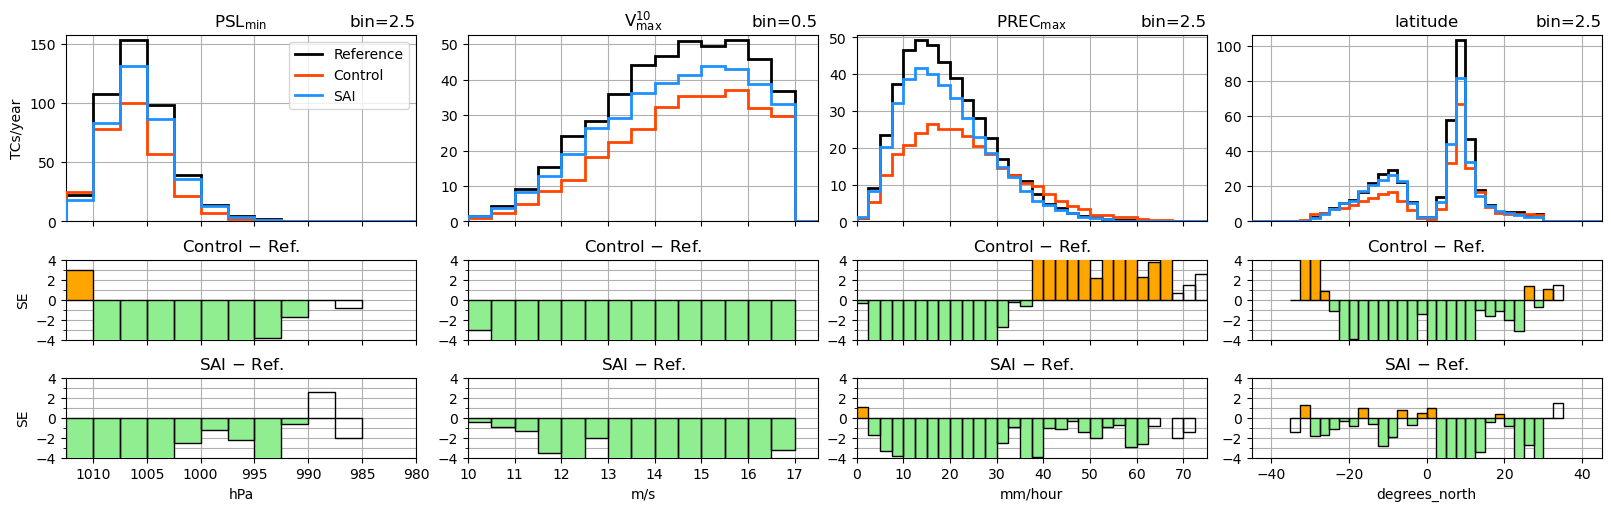

In [12]:
yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
ytag = 'SE' if yunits=='SE' else 'TC'
method = 'maxRV'         # reduction method (passed to track_stat)
plot_vars = ['PSL','U10','PRECT','lat'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)
fname = f"hist_{method}_{ytag}_{'_'.join(plot_vars)}.seeds.pdf"

fig,axs = plt.subplots(3,len(plot_vars), height_ratios=(7,3,3), figsize=(len(plot_vars)*4,5), 
    sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))
ds_max = {exp: tracks.track_stat(ds[exp], method) for exp in ds}
for col,var in enumerate(plot_vars):
    hists = {exp: tracks.histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        tracks.plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

tracks.savefig(fig, fname, **savefigkwargs)

saving ../figures/hist_maxRV_SE_lon_lat_PSLmon_RV.seeds.pdf...


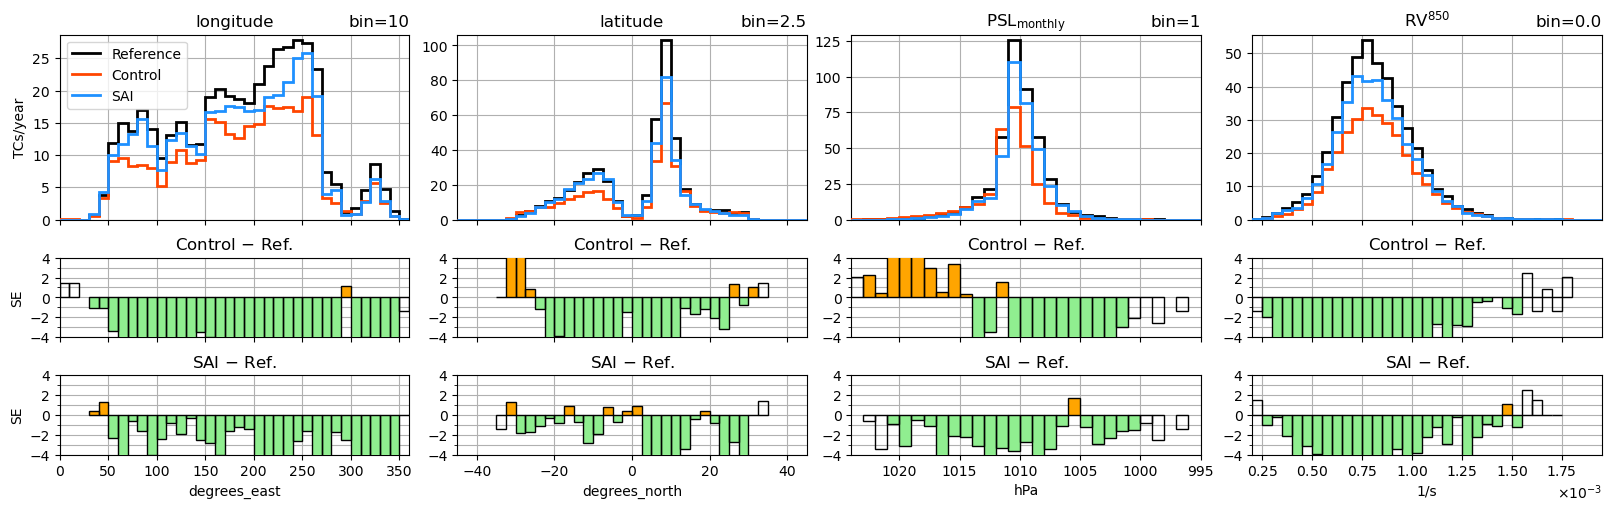

In [18]:
yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
ytag = 'SE' if yunits=='SE' else 'TC'
method = 'maxRV'         # reduction method (passed to track_stat)
plot_vars = ['lon','lat','PSLmon','RV'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)
fname = f"hist_{method}_{ytag}_{'_'.join(plot_vars)}.seeds.pdf"

fig,axs = plt.subplots(3,len(plot_vars), height_ratios=(7,3,3), figsize=(len(plot_vars)*4,5), 
    sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))
ds_max = {exp: tracks.track_stat(ds[exp], method) for exp in ds}
for col,var in enumerate(plot_vars):
    hists = {exp: tracks.histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        tracks.plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

axs[0,3].ticklabel_format(scilimits=(-3,3), useMathText=True) # sci notation for RV
tracks.savefig(fig, fname, **savefigkwargs)

saving ../figures/hist_maxRV_SE_SST_SSTmon_Vshear_TEMP.seeds.pdf...


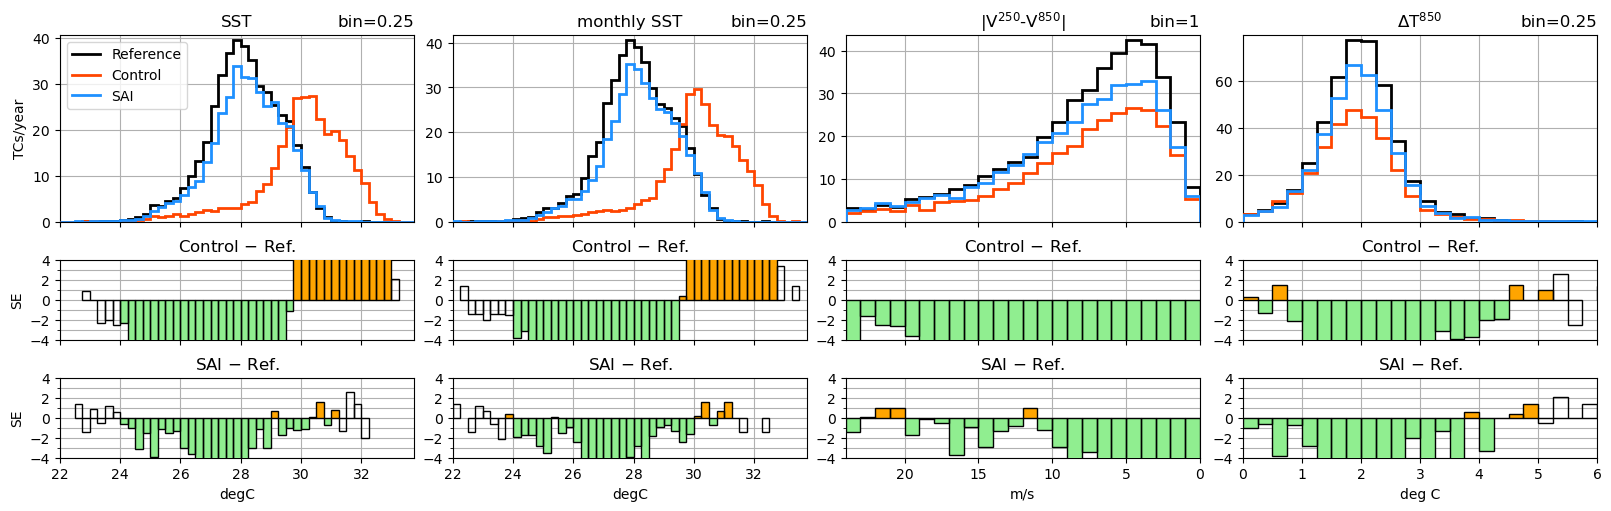

In [19]:
yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
ytag = 'SE' if yunits=='SE' else 'TC'
method = 'maxRV'         # reduction method (passed to track_stat)
plot_vars = ['SST','SSTmon','Vshear','TEMP'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)
fname = f"hist_{method}_{ytag}_{'_'.join(plot_vars)}.seeds.pdf"

fig,axs = plt.subplots(3,len(plot_vars), height_ratios=(7,3,3), figsize=(len(plot_vars)*4,5), 
    sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))
ds_max = {exp: tracks.track_stat(ds[exp], method) for exp in ds}
for col,var in enumerate(plot_vars):
    hists = {exp: tracks.histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        tracks.plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

axs[0,3].set_xlim([0,6])
tracks.savefig(fig, fname, **savefigkwargs)

saving ../figures/hist_develop_SE_SST_Vshear_TEMP.seeds.pdf...


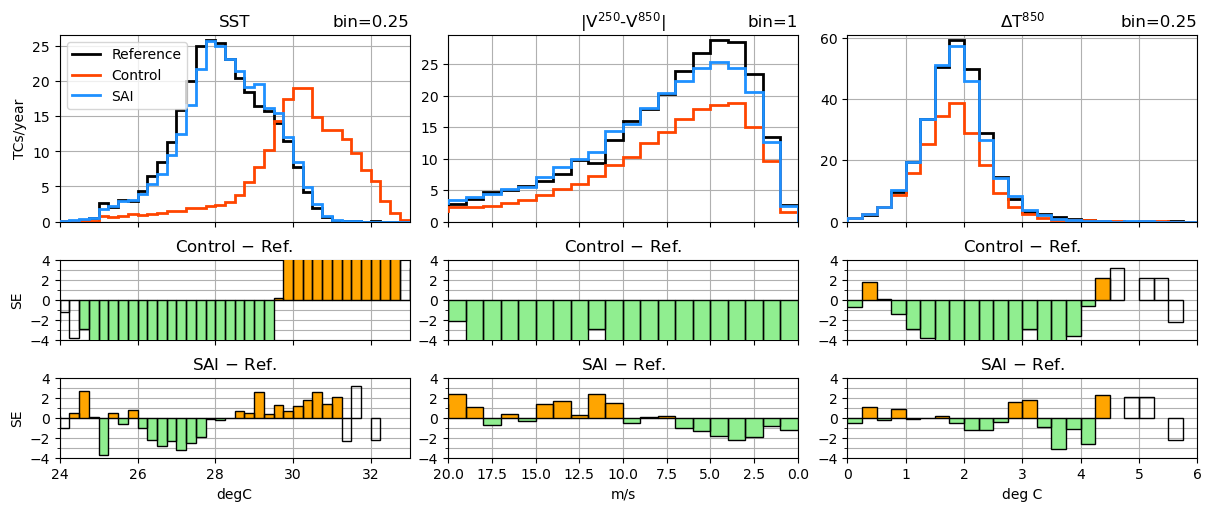

In [20]:
yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
ytag = 'SE' if yunits=='SE' else 'TC'
method = 'develop'         # reduction method (passed to track_stat)
plot_vars = ['SST','Vshear','TEMP'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)
fname = f"hist_{method}_{ytag}_{'_'.join(plot_vars)}.seeds.pdf"

fig,axs = plt.subplots(3,len(plot_vars), height_ratios=(7,3,3), figsize=(len(plot_vars)*4,5), 
    sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))
ds_max = {exp: tracks.track_stat(ds[exp], method) for exp in ds}
for col,var in enumerate(plot_vars):
    hists = {exp: tracks.histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        tracks.plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

axs[0,plot_vars.index('SST')].set_xlim([24,33])
axs[0,plot_vars.index('Vshear')].set_xlim([20,0])
axs[0,plot_vars.index('TEMP')].set_xlim([0,6]) # for core temp anomaly
tracks.savefig(fig, fname, **savefigkwargs)

In [21]:
histREF = tracks.track_density(ds['Reference'], xbins=np.arange(0,360.1,1), ybins=np.arange(-90,90.1,1)).hcount.stack(x=('ens','year'))
histCNT = tracks.track_density(ds['RCP8.5'], xbins=np.arange(0,360.1,1), ybins=np.arange(-90,90.1,1)).hcount.stack(x=('ens','year'))
histSAI = tracks.track_density(ds['SAI2050'], xbins=np.arange(0,360.1,1), ybins=np.arange(-90,90.1,1)).hcount.stack(x=('ens','year'))
hist = xr.concat((histREF,histCNT,histSAI), dim='x').sum('x')
hist = hist.where(hist!=0)

saving ../figures/domains.seeds.pdf...


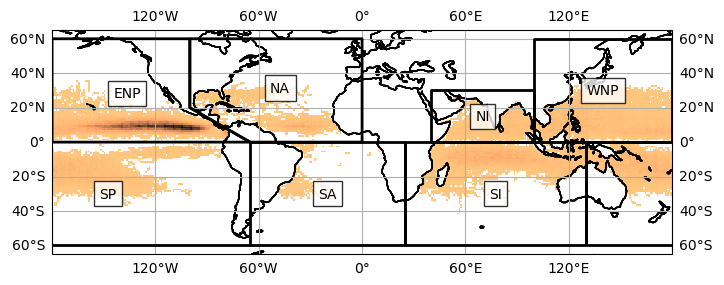

In [22]:
fname = 'domains.seeds.pdf'
fig = plt.figure(figsize=(8,3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((-180,180,-65,65))
for dom in tracks.domains:
    ax.add_geometries(tracks.domains[dom], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2, alpha=1, zorder=5)
    ax.text(tracks.domains[dom].centroid.x, tracks.domains[dom].centroid.y, dom, va='center', ha='center', transform=ccrs.PlateCarree(), 
            zorder=5, bbox=dict(facecolor='white', alpha=0.8))
    ax.coastlines()
    #ax.stock_img()
pcm = ax.pcolormesh(hist.xbins, hist.ybins, hist, transform=ccrs.PlateCarree(), vmin=None, vmax=None, cmap='copper_r', zorder=1)
ax.plot([-180,-65],[-60,-60], transform=ccrs.PlateCarree(), c='k', lw=2, zorder=5)
ax.gridlines(alpha=1, linestyle='-', draw_labels=True, zorder=4)

tracks.savefig(fig, fname, **savefigkwargs)

## Regional figures below are for TCs, not seeds

In [29]:
# estimate for vmin, vmax (track figure)
dom = 'ENP'
tracks.select_region(ds['RCP8.5'], dom).PSL.quantile([0.01,0.5]).data

array([ 973.95558655, 1003.02182007])

../figures/regional/tracks_ENP.pdf already exists, cannot overwrite


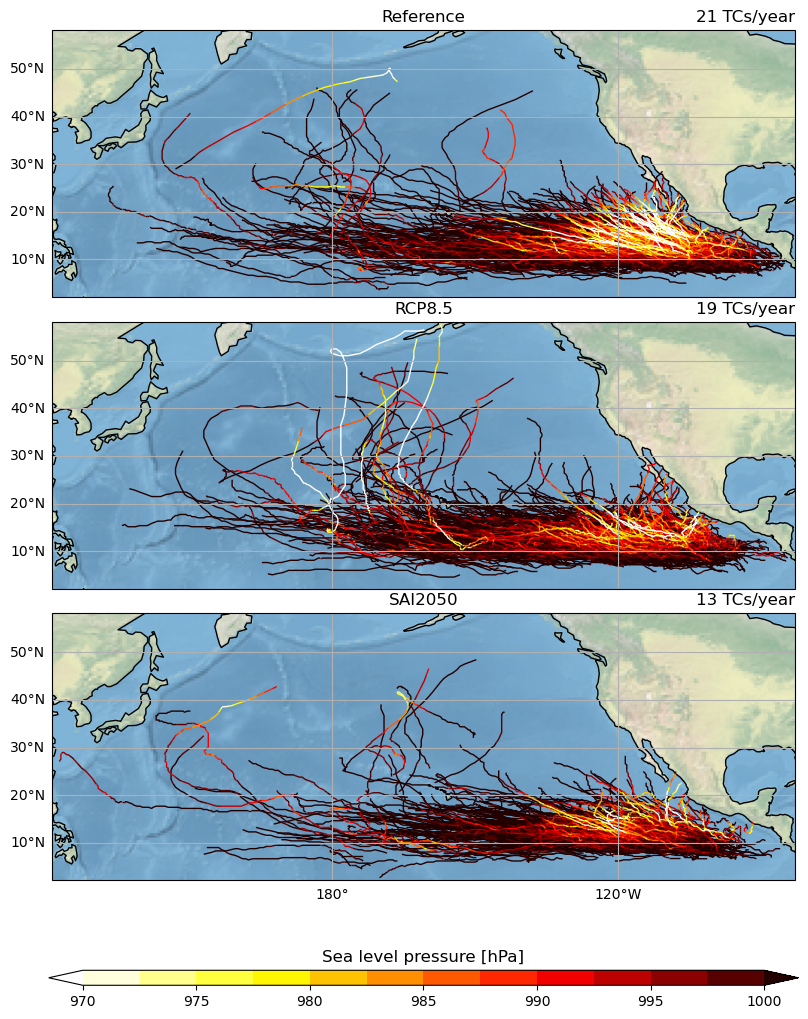

In [30]:
dom = 'ENP'

################### track figure #######################

fname = f'tracks_{dom}.pdf'
fdir = '../figures/regional/'
vmin, vmax = 970, 1000
Nv = round((vmax-vmin)/2.5)+1
clevels = np.linspace(vmin, vmax, Nv)
cmap = plt.get_cmap('hot_r')
central_lon = round(tracks.domains[dom].centroid.x)

fig,axs = plt.subplots(3,1,figsize=(8,10), constrained_layout=True, sharex=True, sharey=True,
                       subplot_kw={'projection':ccrs.PlateCarree(central_longitude=central_lon),
                                   'xmargin':0.01, 'ymargin':0.01})
for exp, ax in zip(ds, axs):
    dsi = tracks.select_region(ds[exp], dom)
    segments = tracks.track_segments(dsi, clevels, central_longitude=central_lon)
    for clevid, segs in segments.items():
        color = cmap((clevid-0.5)/Nv)
        ax.add_collection(LineCollection(segs, color=color, lw=1, 
            transform=ccrs.PlateCarree(central_longitude=central_lon), capstyle='butt'))
    ax.set_title(exp)
    ax.set_title(f'{dsi.id.size/ds[exp].num_days*365:.0f} TCs/year', loc='right')
    ax.coastlines()
    ax.gridlines(draw_labels=(['left','bottom'] if ax==axs[-1] else ['left']))

for ax in axs: # must be after plotting to prevent setting a global view
    ax.stock_img()

# create colorbar
colors = cmap((np.arange(Nv+1)-0.5)/Nv)
lcmap = ListedColormap(colors[1:-1])
lcmap.set_extremes(under=colors[0], over=colors[-1], bad=cmap.get_bad())
cb = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin,vmax=vmax),cmap=lcmap), 
             ax=axs, extend='both', orientation='horizontal', aspect=50, shrink=1)
cb.ax.set_title('Sea level pressure [hPa]')

tracks.savefig(fig, fname, figpath=fdir, **savefigkwargs)

../figures/regional/hist_maxRV_WNP_SE_PSL_U10_PRECT_lat.pdf already exists, cannot overwrite


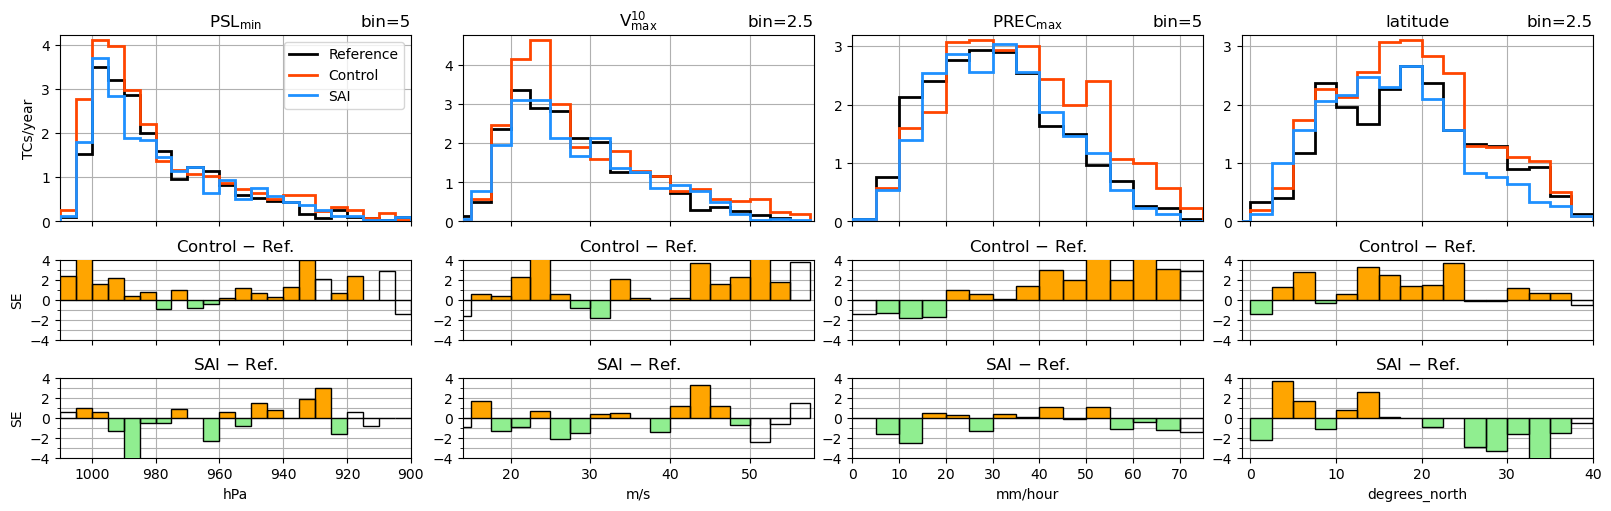

In [31]:
############## PSL, RMW, V, PREC figure @ max RV ######################

dom = 'WNP'
method = 'maxRV'         # reduction method (passed to track_stat)
yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
ytag = 'SE' if yunits=='SE' else 'TC'
plot_vars = ['PSL','U10','PRECT','lat'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)
fname = f"hist_{method}_{dom}_{ytag}_{'_'.join(plot_vars)}.pdf"
fdir = '../figures/regional/'

hist_kwargs = {
    'lon': {'bins': np.arange(0,361,10), 'title': 'longitude', 'rev':False},
    'lat': {'bins': np.arange(-45,45.1,2.5), 'title': 'latitude', 'rev':False},
    'PSL': {'bins': np.arange(900,1015,5), 'title': r'PSL$_{\mathrm{min}}$', 'rev':True},
    'PSLmon': {'bins': np.arange(995,1025,1), 'title': r'PSL$_{\mathrm{monthly}}$', 'rev':True},
    'U10': {'bins': np.arange(10,60,2.5), 'title': r'V$^{10}_{\mathrm{max}}$', 'rev':False},
    'RMW': {'bins': np.arange(20,150,5), 'title': r'RMW$^{10}$', 'rev':True}, 
    'SST': {'bins': np.arange(22,34,0.25), 'title': 'SST', 'rev':False},
    'SSTmon': {'bins': np.arange(22,34,0.25), 'title': 'monthly SST', 'rev':False},
    'RV': {'bins': np.arange(4e-4,4e-3,1e-4), 'title': r'RV$^{850}$', 'rev':False},
    'Vshear': {'bins': np.arange(0,25,1), 'title': r'|V$^{250}$-V$^{850}$|', 'rev':True},
    'PRECT':{'bins': np.arange(0,76,5), 'title': r'PREC$_{\mathrm{max}}$', 'rev':False},
    'TEMP': {'bins': np.arange(0,10,0.25), 'title': r'$\Delta$T$^{850}$', 'rev':False},
}

# hist_kwargs['PSL']['bins'] = np.arange(900,1015,5)
# hist_kwargs['U10']['bins'] = np.arange(10,60,2.5)
# hist_kwargs['PRECT']['bins'] = np.arange(0,76,5)
# hist_kwargs['lat']['bins'] = np.arange(-45,45.1,2.5)

fig,axs = plt.subplots(3,4, height_ratios=(7,3,3), figsize=(16,5), sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))

dsi = {exp: tracks.select_region(ds[exp], dom) for exp in ds}
dsi = {exp: tracks.track_stat(dsi[exp], method=method) for exp in dsi}
#xlims = dsi['Reference'].quantile([0.0,1])

for col,var in enumerate(plot_vars):
    hists = {exp: tracks.histogram(dsi[exp][var], hist_kwargs[var]['bins']) for exp in dsi}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        tracks.plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(dsi['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    # axs[2,col].set_xlim(xlims[var])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

# axs[0,0].set_xlim([1015,945])
axs[0,1].set_xlim([14,58])
# axs[0,2].set_xlim([0,50])
axs[0,3].set_xlim([-1,40])

tracks.savefig(fig, fname, figpath=fdir, **savefigkwargs)

../figures/regional/hist_develop_WNP_SE_Vshear_SST.pdf already exists, cannot overwrite


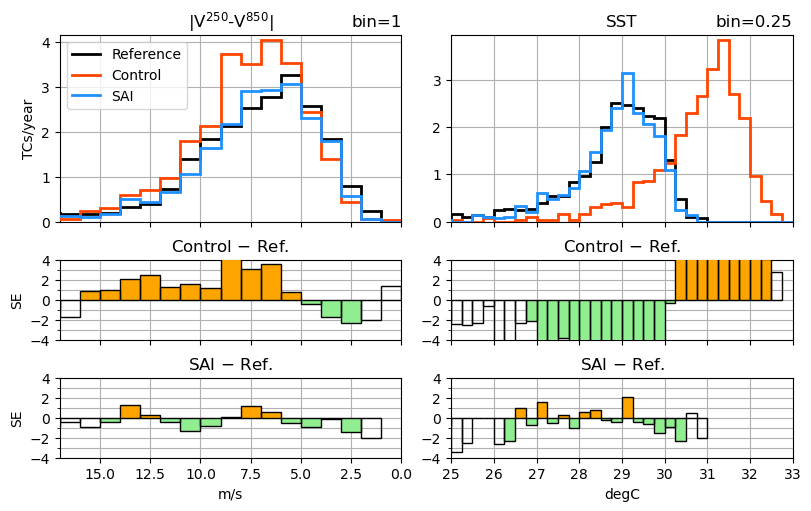

In [32]:
############### SHEAR, SST figure #################

dom = 'WNP'
method = 'develop'         # reduction method (passed to track_stat)
yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
ytag = 'SE' if yunits=='SE' else 'TC'
plot_vars = ['Vshear','SST'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)
fname = f"hist_{method}_{dom}_{ytag}_{'_'.join(plot_vars)}.pdf"
fdir = '../figures/regional/'

#fig,axs = plt.subplots(3,len(plot_vars), height_ratios=(7,3,3), figsize=(len(plot_vars)*4,5), sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))
fig,axs = plt.subplots(3,2, height_ratios=(7,3,3), figsize=(len(plot_vars)*4,5), 
    sharex='col', layout='constrained', subplot_kw=dict(xmargin=0.01, ymargin=0.03))
if len(plot_vars) == 1:
    axs = axs[:,np.newaxis]

dsi = {exp: tracks.select_region(ds[exp], dom) for exp in ds}
dsi = {exp: tracks.track_stat(dsi[exp], method=method) for exp in dsi}

for col,var in enumerate(plot_vars):
    hists = {exp: tracks.histogram(dsi[exp][var], hist_kwargs[var]['bins']) for exp in dsi}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        tracks.plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(dsi['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

axs[0,0].set_xlim([17,0])
axs[0,1].set_xlim([25,33])

tracks.savefig(fig, fname, figpath=fdir, **savefigkwargs)

Text(0.5, 1.0, 'Bootstrapped')

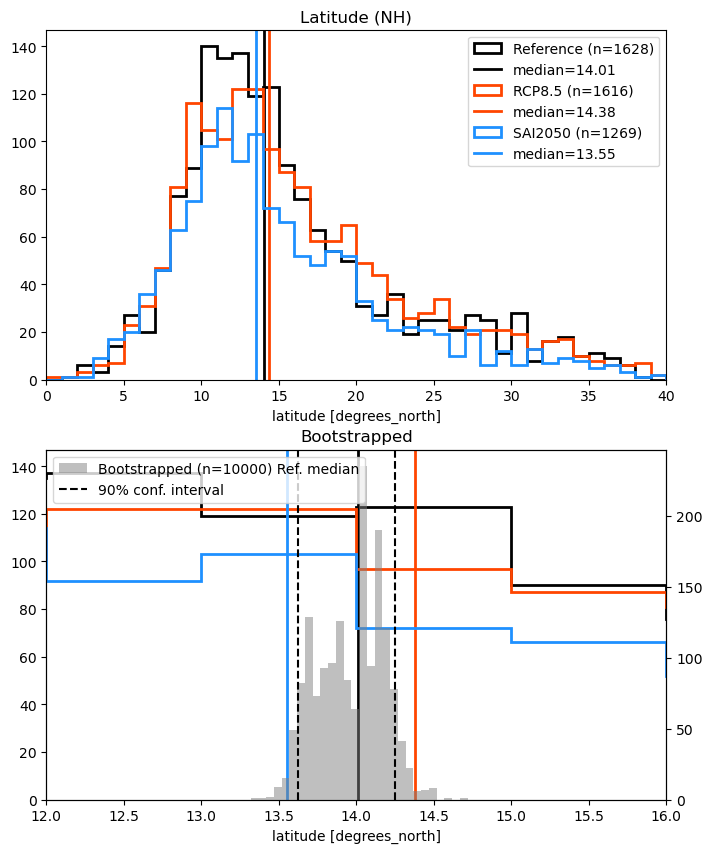

In [33]:
ds_stat = {method: {exp: tracks.track_stat(ds[exp], method) for exp in ds} 
           for method in ['mean','maxRV','develop','maxdeep']}
bins = np.arange(0,91)
fig, axs = plt.subplots(2,1, figsize=(8,10))
for exp in ds:
    lats = ds_stat['mean'][exp].lat
    lats_NH = lats.where(lats>=0, drop=True)
    lats_NH.plot.hist(ax=axs[0], bins=bins, histtype='step', **(default_kwargs[exp] | {'label':exp+f' (n={lats_NH.id.size})'}))
    lats_NH.plot.hist(ax=axs[1], bins=bins, histtype='step', **(default_kwargs[exp] | {'label':exp+f' (n={lats_NH.id.size})'}))
    axs[0].axvline(lats_NH.median(), **(default_kwargs[exp] | {'label':f"median={lats_NH.median():.2f}"}))
    axs[1].axvline(lats_NH.median(), **(default_kwargs[exp] | {'label':f"median={lats_NH.median():.2f}"}))
axs[0].legend()
axs[0].set_xlim([0,40])
axs[0].set_title('Latitude (NH)')

lats = ds_stat['mean']['Reference'].lat
lats_NH = lats.where(lats>=0, drop=True)
all_quants = tracks.bootstrap(lats_NH, np.quantile, [0.5], qs=np.linspace(0,1,len(lats_NH)))
confidence_lims2 = tracks.bootstrap(lats_NH, np.quantile, [0.5])

ax2 = axs[1].twinx()
hist,edges = np.histogram(all_quants, bins=np.arange(all_quants.min(),all_quants.max()+0.04, 0.05))
ax2.stairs(hist, fill=True, alpha=0.5, color='gray', edges=edges, label=f'Bootstrapped (n=10000) Ref. median')
ax2.axvline(confidence_lims2[0], c='k', ls='--', label='90% conf. interval')
ax2.axvline(confidence_lims2[1], c='k', ls='--')
ax2.legend()
axs[1].set_xlim([12,16])
axs[1].set_title('Bootstrapped') 